In [63]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 

In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
# Configure variables for Transfer learning
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 32
dataset_root =r'/kaggle/input/daioapd/Dataset'

In [3]:
train_dir = os.path.join(dataset_root, "/kaggle/input/daioapd/Dataset/traning")
test_dir = os.path.join(dataset_root, "/kaggle/input/daioapd/Dataset/test")


In [4]:
# Attention Module
def Attention(input_tensor, filters):
    x = layers.Conv2D(filters // 8, (1, 1), activation='relu')(input_tensor)
    y = layers.Conv2D(filters // 8, (1, 1), activation='relu')(input_tensor)
    z = layers.Conv2D(filters, (1, 1), activation='relu')(input_tensor)

    f = tf.keras.layers.add([x, y])
    f = layers.Conv2D(filters, (1, 1), activation='relu')(f)

    attention = tf.keras.layers.multiply([z, f])
    return attention

In [5]:
train_aug=ImageDataGenerator(
    rescale=1/255.0,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
)

In [6]:
# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)


Found 10502 images belonging to 7 classes.


In [7]:
test_aug=ImageDataGenerator(
    rescale=1/255.0,
)

In [8]:
# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1400 images belonging to 7 classes.


In [9]:
gpus=tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

In [10]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)
mbnet_v2.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# ASPP Output
#aspp_output = ASPP(mbnet_v2.output, filters=256)



In [12]:
gpus=tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

In [13]:
# Attention Output
attention_output = Attention(mbnet_v2.output, filters=256)

In [14]:
# Combined Features
combined_features = layers.Concatenate()([mbnet_v2.output, attention_output])

In [15]:
# Additional Layers
cats = 7
x = layers.GlobalAveragePooling2D()(combined_features)
x = layers.Dropout(0.3)(x)
x = layers.Dense(cats, activation="softmax")(x)


In [16]:
# Create Model
model = Model(inputs=mbnet_v2.input, outputs=x)

In [17]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=5)


In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,687,111 (10.25 MB)

 Trainable params: 429,127 (1.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# Train the model
history =  model.fit(
    train_data,
    epochs=30,
    validation_data=test_data,
    callbacks=[early_stopping_cb]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729267719.734963     123 service.cc:145] XLA service 0x7afb4c003860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729267719.735027     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729267719.735033     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/329 ━━━━━━━━━━━━━━━━━━━━ 2:11:00 24s/step - accuracy: 0.1250 - loss: 2.6170

I0000 00:00:1729267728.599449     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 ━━━━━━━━━━━━━━━━━━━━ 350s 993ms/step - accuracy: 0.4484 - loss: 1.5031 - val_accuracy: 0.8393 - val_loss: 0.4647
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 261s 775ms/step - accuracy: 0.8337 - loss: 0.4699 - val_accuracy: 0.8850 - val_loss: 0.3326
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 259s 772ms/step - accuracy: 0.8715 - loss: 0.3592 - val_accuracy: 0.8736 - val_loss: 0.3620
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 261s 772ms/step - accuracy: 0.8865 - loss: 0.3168 - val_accuracy: 0.8971 - val_loss: 0.3040
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 274s 815ms/step - accuracy: 0.8983 - loss: 0.2758 - val_accuracy: 0.9007 - val_loss: 0.3001
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 258s 768ms/step - accuracy: 0.9109 - loss: 0.2493 - val_accuracy: 0.8800 - val_loss: 0.3698
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 258s 766ms/step - accuracy: 0.9228 - loss: 0.2122 - val_accuracy: 0.9136 - val_loss: 0.2623
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 258s 766ms/step - accuracy: 0.9238 - loss: 0.21

In [21]:
model.save("Modelplant_newplant_aspp_plantdetection.h5")

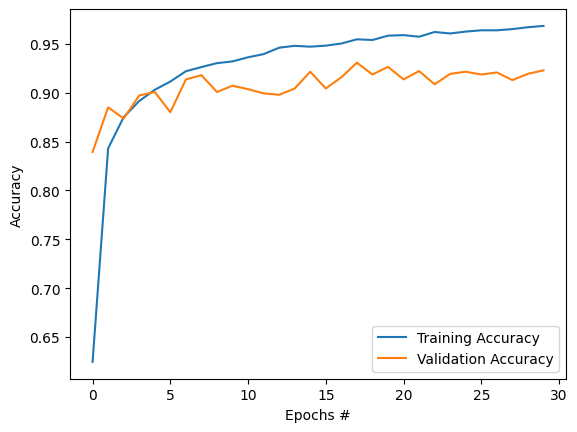

In [22]:
# Plotting accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
if "val_accuracy" in history.history:
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

# Add the labels and legend
plt.ylabel("Accuracy")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

Found 700 images belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 999ms/step


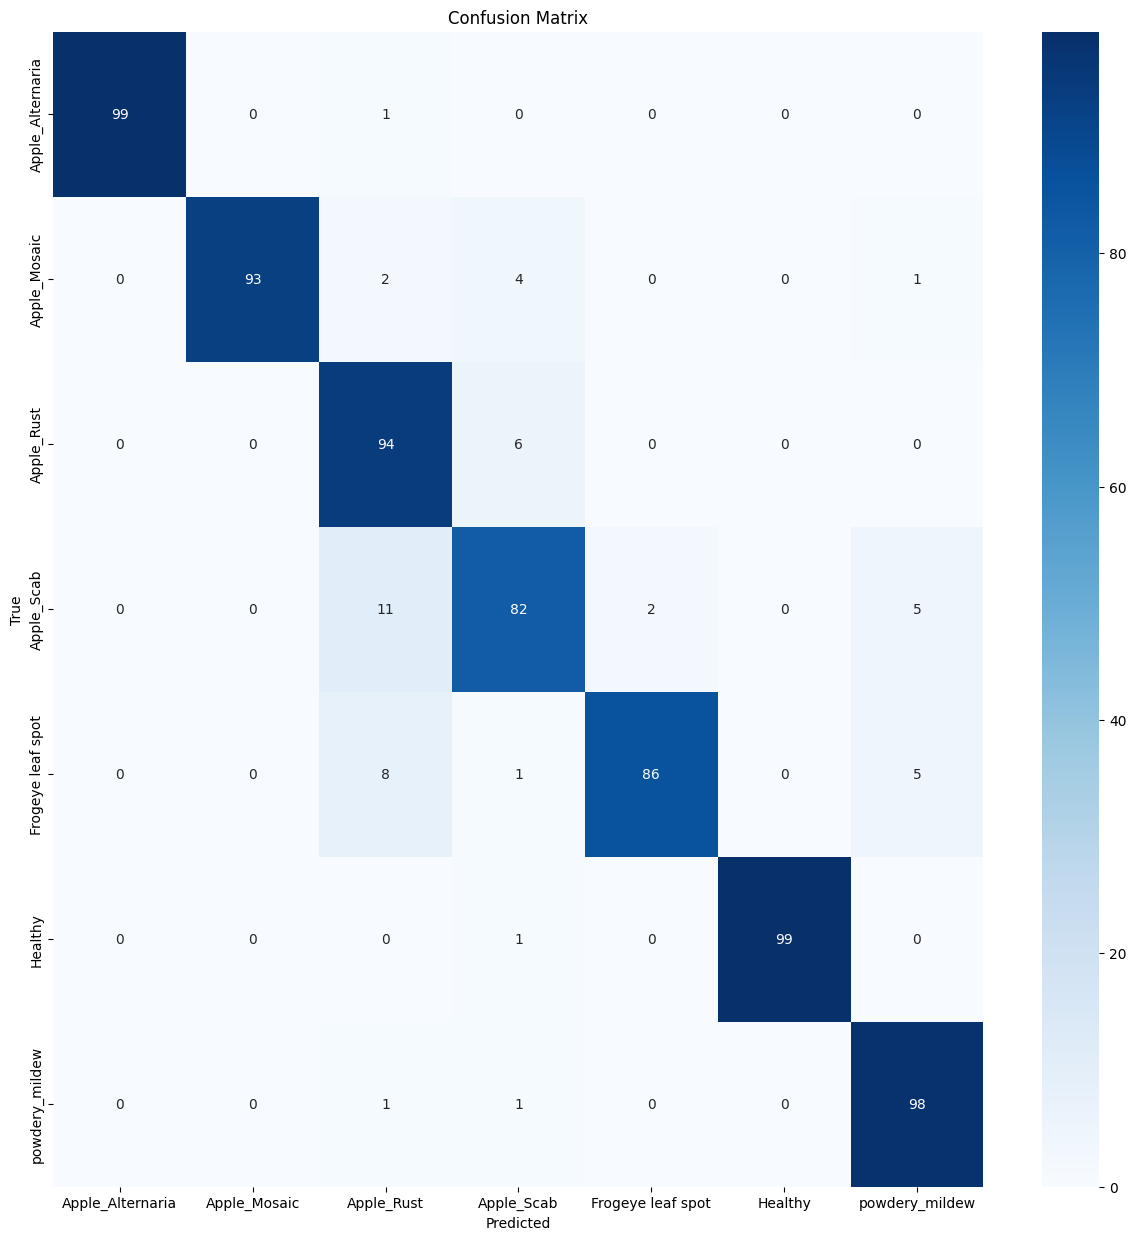

Classification Report:
                   precision    recall  f1-score   support

 Apple_Alternaria       1.00      0.99      0.99       100
     Apple_Mosaic       1.00      0.93      0.96       100
       Apple_Rust       0.80      0.94      0.87       100
       Apple_Scab       0.86      0.82      0.84       100
Frogeye leaf spot       0.98      0.86      0.91       100
          Healthy       1.00      0.99      0.99       100
   powdery_mildew       0.90      0.98      0.94       100

         accuracy                           0.93       700
        macro avg       0.93      0.93      0.93       700
     weighted avg       0.93      0.93      0.93       700



In [23]:

from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have a directory structure for your test data
valid_data_dir = r'/kaggle/input/daioapd/Dataset/valid'
target_size = (224, 224)  # Adjust based on your model's input size
batch_size = 32  # Adjust based on your preferences

# Set up the ImageDataGenerator for test data
valid_data_generator = ImageDataGenerator(rescale=1/255.0)  # You may need to apply the same preprocessing as in training

# Generate batches of test data
valid_data_flow = valid_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",  # Adjust based on your data
    shuffle=False  # Set to False to keep the order of predictions in sync with true labels
)
# Get the true labels
true_labels = valid_data_flow.classes

# Use the model to predict the labels for the test data
predicted_labels = model.predict(valid_data_flow)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_data_flow.class_indices, yticklabels=valid_data_flow.class_indices)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=valid_data_flow.class_indices.keys()))

Found 700 images belonging to 7 classes.
 3/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step


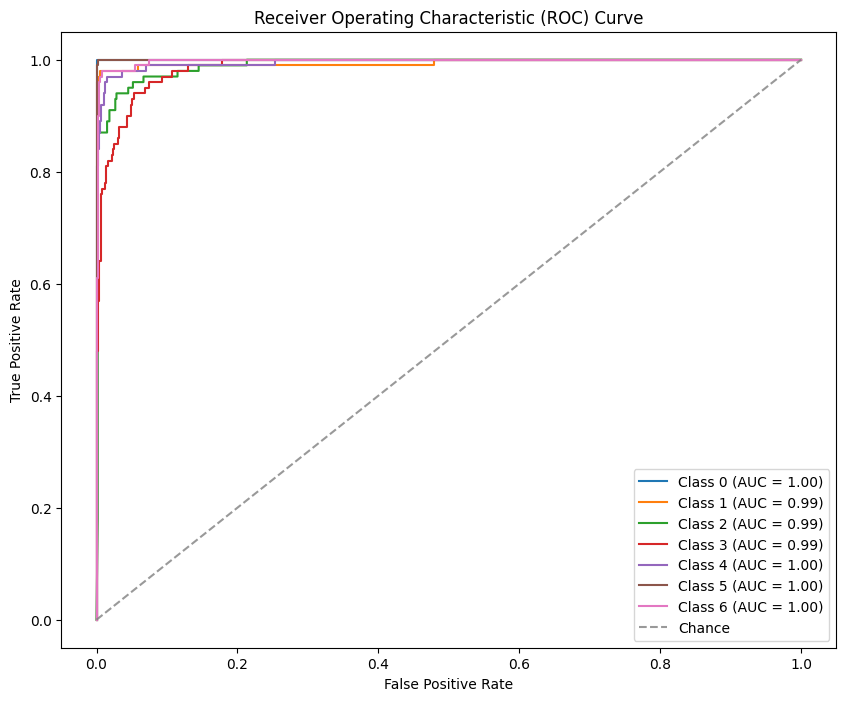

In [24]:

from sklearn.metrics import roc_curve, auc

# Assuming you have a directory structure for your test data
valid_data_dir = r'/kaggle/input/daioapd/Dataset/valid'
target_size = (224, 224)  # Adjust based on your model's input size
batch_size = 32  # Adjust based on your preferences

# Set up the ImageDataGenerator for test data
valid_data_generator = ImageDataGenerator(rescale=1/255.0)  # You may need to apply the same preprocessing as in training

# Generate batches of valid data

valid_data_flow = valid_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Get the true labels
true_labels = valid_data_flow.classes

# Use the model to predict the labels for the test data
predicted_labels = model.predict(valid_data_flow)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(valid_data_flow.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_labels[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(len(valid_data_flow.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
import json 
from IPython.display import FileLink
FileLink(".new_model_aspp_detection.h5")

/kaggle/working/.new_model_aspp_detection.h5

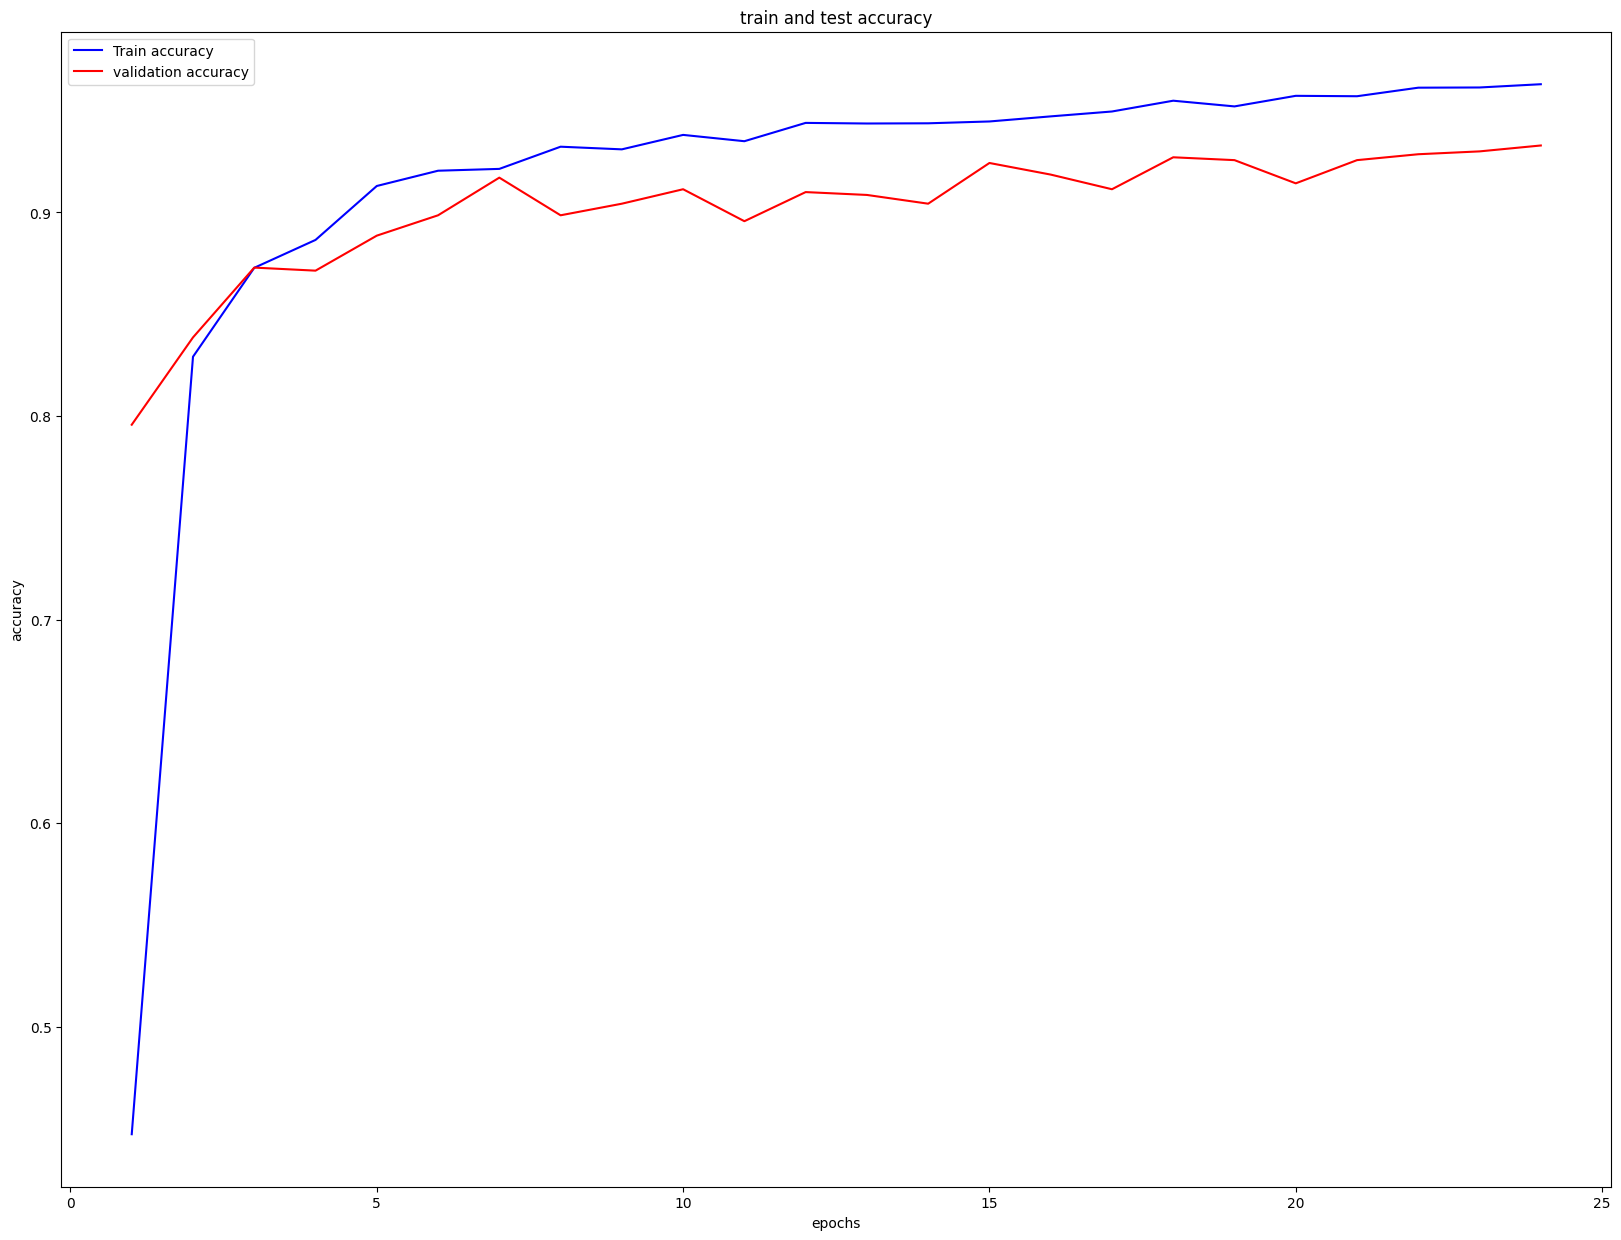

In [26]:
validation_accuracy=[0.7957,0.8386,0.8729,0.8714,0.8886,0.8986,0.9171,0.8986,0.9043,0.9114,0.8957,0.9100,0.9086,0.9043,0.9243,0.9186,0.9114,0.9271,0.9257,0.9143,0.9257,0.9286,0.9300,0.9329]
train_accuracy=[0.4471,0.8291,0.8728,0.8865,0.9130,0.9205,0.9214,0.9323,0.9310,0.9381,0.9350,0.9440, 0.9437,0.9438,0.9447,0.9472,0.9496,0.9549,0.9521,0.9573,0.9571,0.9613,0.9614,0.9630 ]
epochs=range(1, len(train_accuracy)+1)
plt.figure(figsize=(20,15))
plt.plot(epochs,train_accuracy,'b',label="Train accuracy")
plt.plot(epochs,validation_accuracy,'r',label="validation accuracy")
plt.title("train and test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

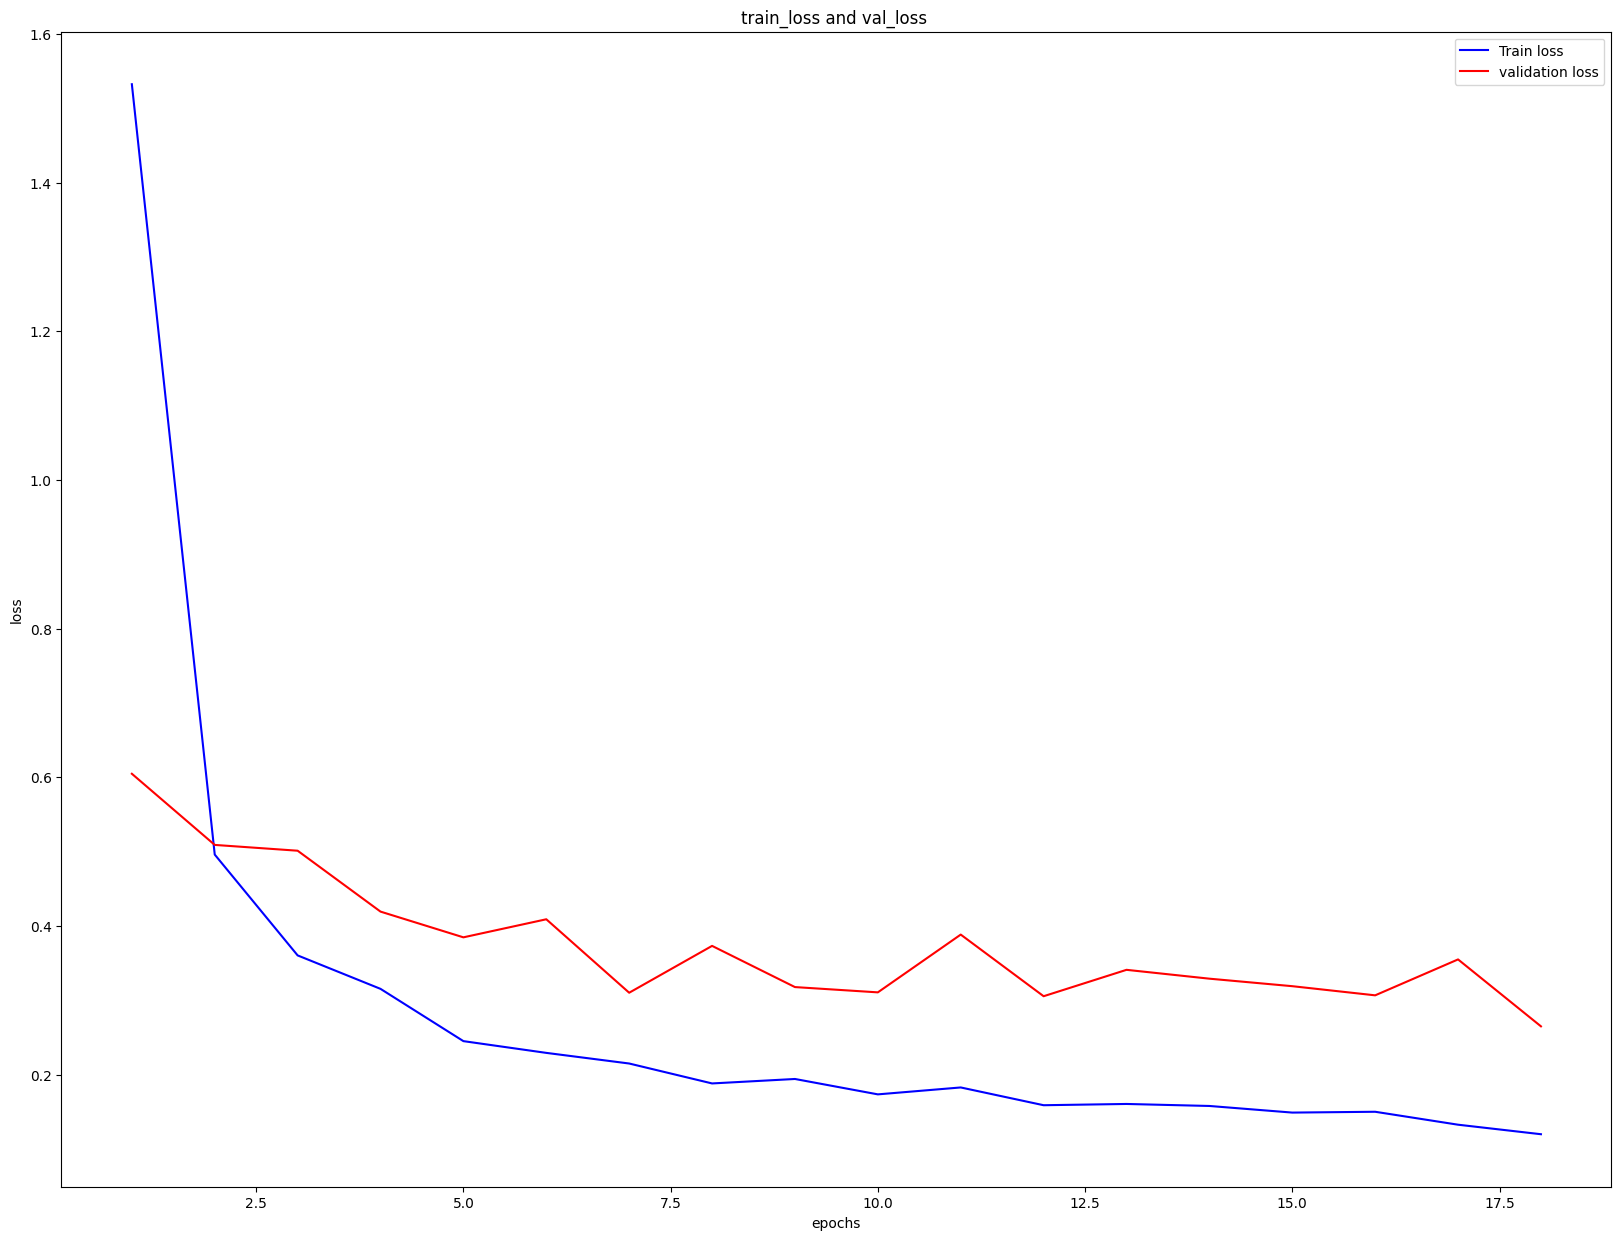

In [27]:
validation_loss=[0.6048,0.5091,0.5013,0.4194,0.3848,0.4091,0.3103,0.3733,0.3179,0.3108,0.3885,0.3056,0.3411,0.3292,0.3191,0.3068,0.3551,0.2651]

train_loss=[1.5322,0.4961,0.3605,0.3155,0.2452,0.2294,0.2151,0.1883,0.1943,0.1736,0.1829,0.1590,0.1607,0.1580,0.1491,0.1502,0.1328,0.1200]
epochs=range(1, len(train_loss)+1)
plt.figure(figsize=(20,15))
plt.plot(epochs,train_loss,'b',label="Train loss")
plt.plot(epochs,validation_loss,'r',label="validation loss")
plt.title("train_loss and val_loss ")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Found 700 images belonging to 7 classes.
 3/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step


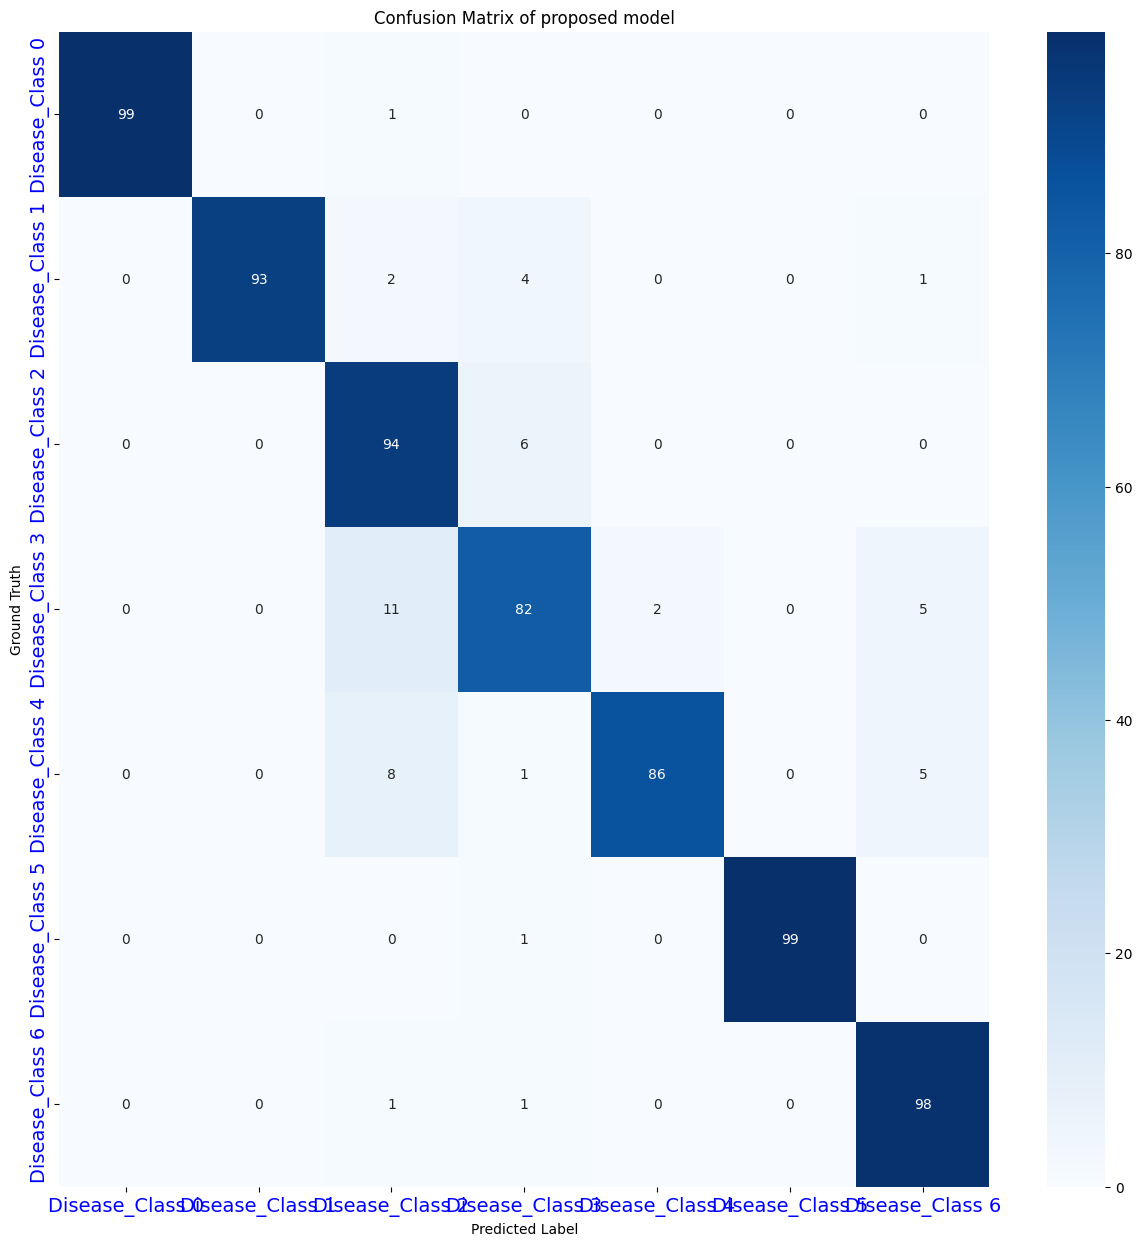

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       100
     Class 1       1.00      0.93      0.96       100
     Class 2       0.80      0.94      0.87       100
     Class 3       0.86      0.82      0.84       100
     Class 4       0.98      0.86      0.91       100
     Class 5       1.00      0.99      0.99       100
     Class 6       0.90      0.98      0.94       100

    accuracy                           0.93       700
   macro avg       0.93      0.93      0.93       700
weighted avg       0.93      0.93      0.93       700



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have a directory structure for your test data
valid_data_dir = r'/kaggle/input/daioapd/Dataset/valid'
target_size = (224, 224)  # Adjust based on your model's input size
batch_size = 32  # Adjust based on your preferences

# Set up the ImageDataGenerator for test data
valid_data_generator = ImageDataGenerator(rescale=1/255.0)  # You may need to apply the same preprocessing as in training

# Generate batches of test data
valid_data_flow = valid_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",  # Adjust based on your data
    shuffle=False  # Set to False to keep the order of predictions in sync with true labels
)

# Get the true labels
true_labels = valid_data_flow.classes

# Use the model to predict the labels for the test data
predicted_labels = model.predict(valid_data_flow)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Disease_Class {i}' for i in range(len(valid_data_flow.class_indices))], yticklabels=[f'Disease_Class {i}' for i in range(len(valid_data_flow.class_indices))])

# Increase font size of class labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14, color='blue')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14, color='blue')

plt.xlabel("Predicted Label")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix of proposed model")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=[f'Class {i}' for i in range(len(valid_data_flow.class_indices))]))


Found 700 images belonging to 7 classes.
 3/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step


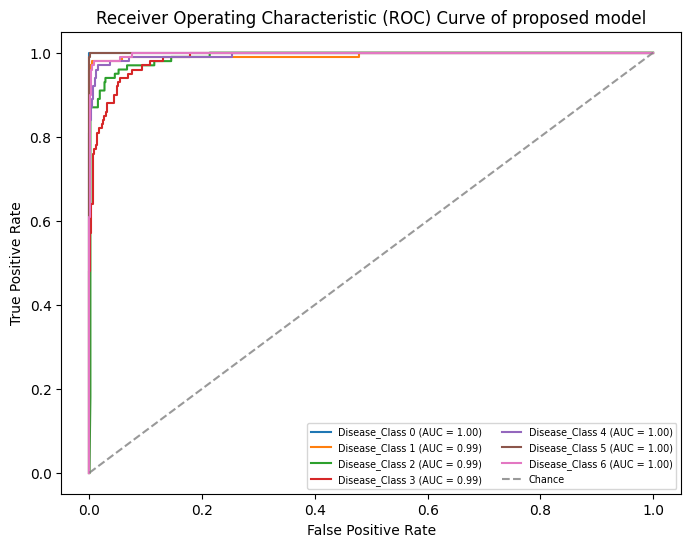

In [29]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory structure for your test data
valid_data_dir = r'/kaggle/input/daioapd/Dataset/valid'
target_size = (224, 224)  # Adjust based on your model's input size
batch_size = 32  # Adjust based on your preferences

# Set up the ImageDataGenerator for test data
valid_data_generator = ImageDataGenerator(rescale=1/255.0)  # You may need to apply the same preprocessing as in training

# Generate batches of valid data
valid_data_flow = valid_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Get the true labels
true_labels = valid_data_flow.classes

# Use the model to predict the labels for the test data
predicted_labels = model.predict(valid_data_flow)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(valid_data_flow.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_labels[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(len(valid_data_flow.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'Disease_Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of proposed model')
plt.legend(loc="lower right", ncol=2, fontsize='x-small')  # Set the number of columns to 2 and reduce the font size
plt.show()


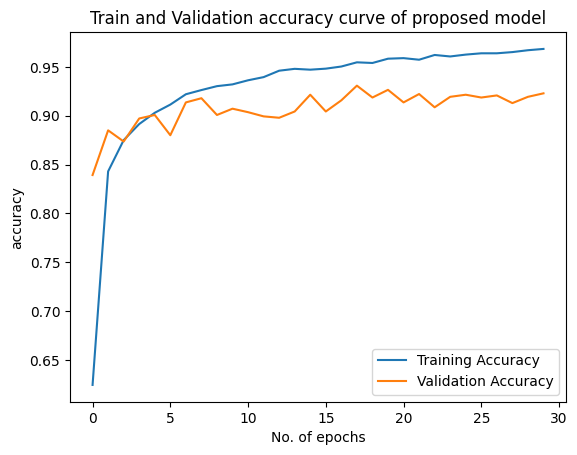

In [30]:

# Plot the accuracy graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Train and Validation accuracy curve of proposed model")
plt.xlabel("No. of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

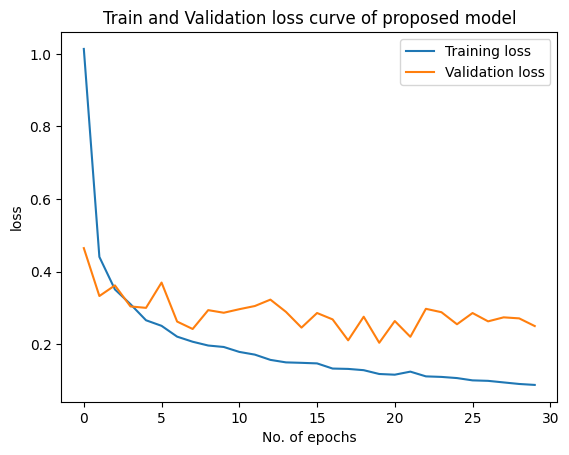

In [31]:
# Plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Train and Validation loss curve of proposed model")
plt.xlabel("No. of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [32]:
model.save("proposedmodel_sampled_dataset.h5")